<a href="https://colab.research.google.com/github/bernia/MachineLearning/blob/master/tf_tutorials/overfit_and_underfit_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overfit and Underfit

In [1]:
# Setup
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [0]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
# Load Dataset

gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 60s 0us/step


In [0]:
FEATURES = 28

In [0]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [0]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [0]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


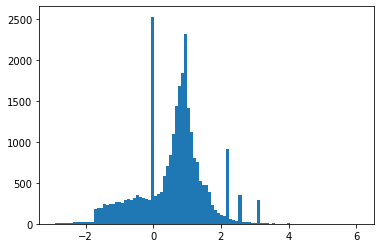

In [9]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [0]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [0]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [12]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [0]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

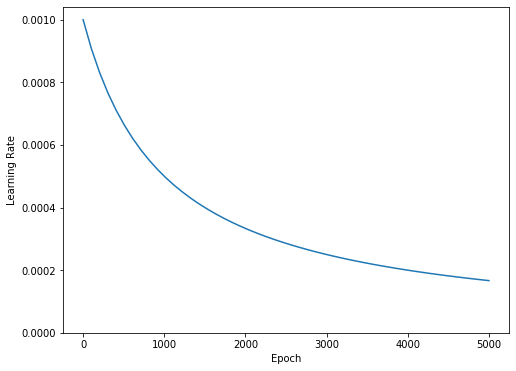

In [14]:
# Model

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [0]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [0]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [0]:
# Tiny model
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [0]:
size_histories = {}

In [25]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4773,  binary_crossentropy:0.8888,  loss:0.8888,  val_accuracy:0.5080,  val_binary_crossentropy:0.7523,  val_loss:0.7523,  
....................................................................................................
Epoch: 100, accuracy:0.5987,  binary_crossentropy:0.6295,  loss:0.6295,  val_accuracy:0.5910,  val_binary_crossentropy:0.6276,  val_loss:0.6276,  
....................................................................................................
Epoch: 200, accuracy:0.

(0.5, 0.7)

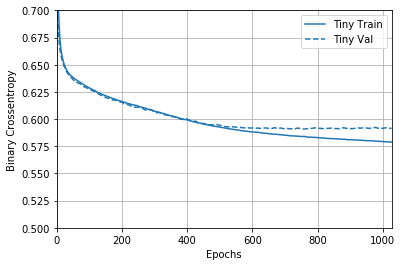

In [26]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [0]:
# Small model
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [28]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4828,  binary_crossentropy:0.7402,  loss:0.7402,  val_accuracy:0.4570,  val_binary_crossentropy:0.7088,  val_loss:0.7088,  
....................................................................................................
Epoch: 100, accuracy:0.6385,  binary_crossentropy:0.6053,  loss:0.6053,  val_accuracy:0.6470,  val_binary_crossentropy:0.6000,  val_loss:0.

In [0]:
# Medium model
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [30]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4866,  binary_crossentropy:0.6909,  loss:0.6909,  val_accuracy:0.4730,  val_binary_crossentropy:0.6737,  val_loss:0.6737,  
....................................................................................................
E

In [0]:
# Large model
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [32]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5075,  binary_crossentropy:0.8031,  loss:0.8031,  val_accuracy:0.4700,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

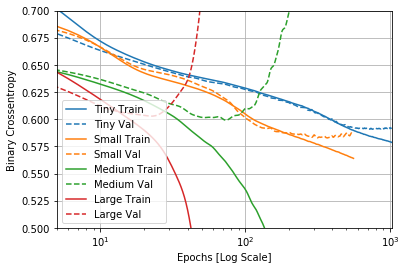

In [33]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [34]:
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [35]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")